In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_80/4269095638.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [5]:
def phase_addition(circuit, reg1, reg2, reg3):

    # 位相の単位
    dphi = 2. * np.pi / (2 ** reg3.size)

    # reg1とreg2それぞれの量子ビットで制御する
    for reg_ctrl in [reg1, reg2]:
        for ictrl, qctrl in enumerate(reg_ctrl):
            circuit.barrier()
            # reg1, reg2の位相をreg3にかけていく
            for itarg, qtarg in enumerate(reg3):
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)

    circuit.barrier()

In [6]:
# 量子フーリエ変換を施す関数
def qft(qc, reg):
    n = reg.size  # QuantumRegisterのサイズを取得
    for i in range(n - 1, 0, -1):
        qc.h(reg[i])
        for j in range(i - 1, -1, -1):
            qc.cp(np.pi / (2 ** (i - j)), reg[j], reg[i])
        qc.barrier()
    qc.h(reg[0])
    for i in range(0, n // 2):
        qc.swap(reg[i], reg[n - i - 1])


# 逆量子フーリエ変換を施す関数
def inverse_qft(qc, reg):
    n = reg.size  # QuantumRegisterのサイズを取得
    for i in range(n // 2):
        qc.swap(reg[i], reg[n - i - 1])
    for i in range(n):
        qc.h(reg[i])
        for j in range(i + 1, n):
            qc.cp(-np.pi / (2 ** (j - i)), reg[j], reg[i])
        qc.barrier()


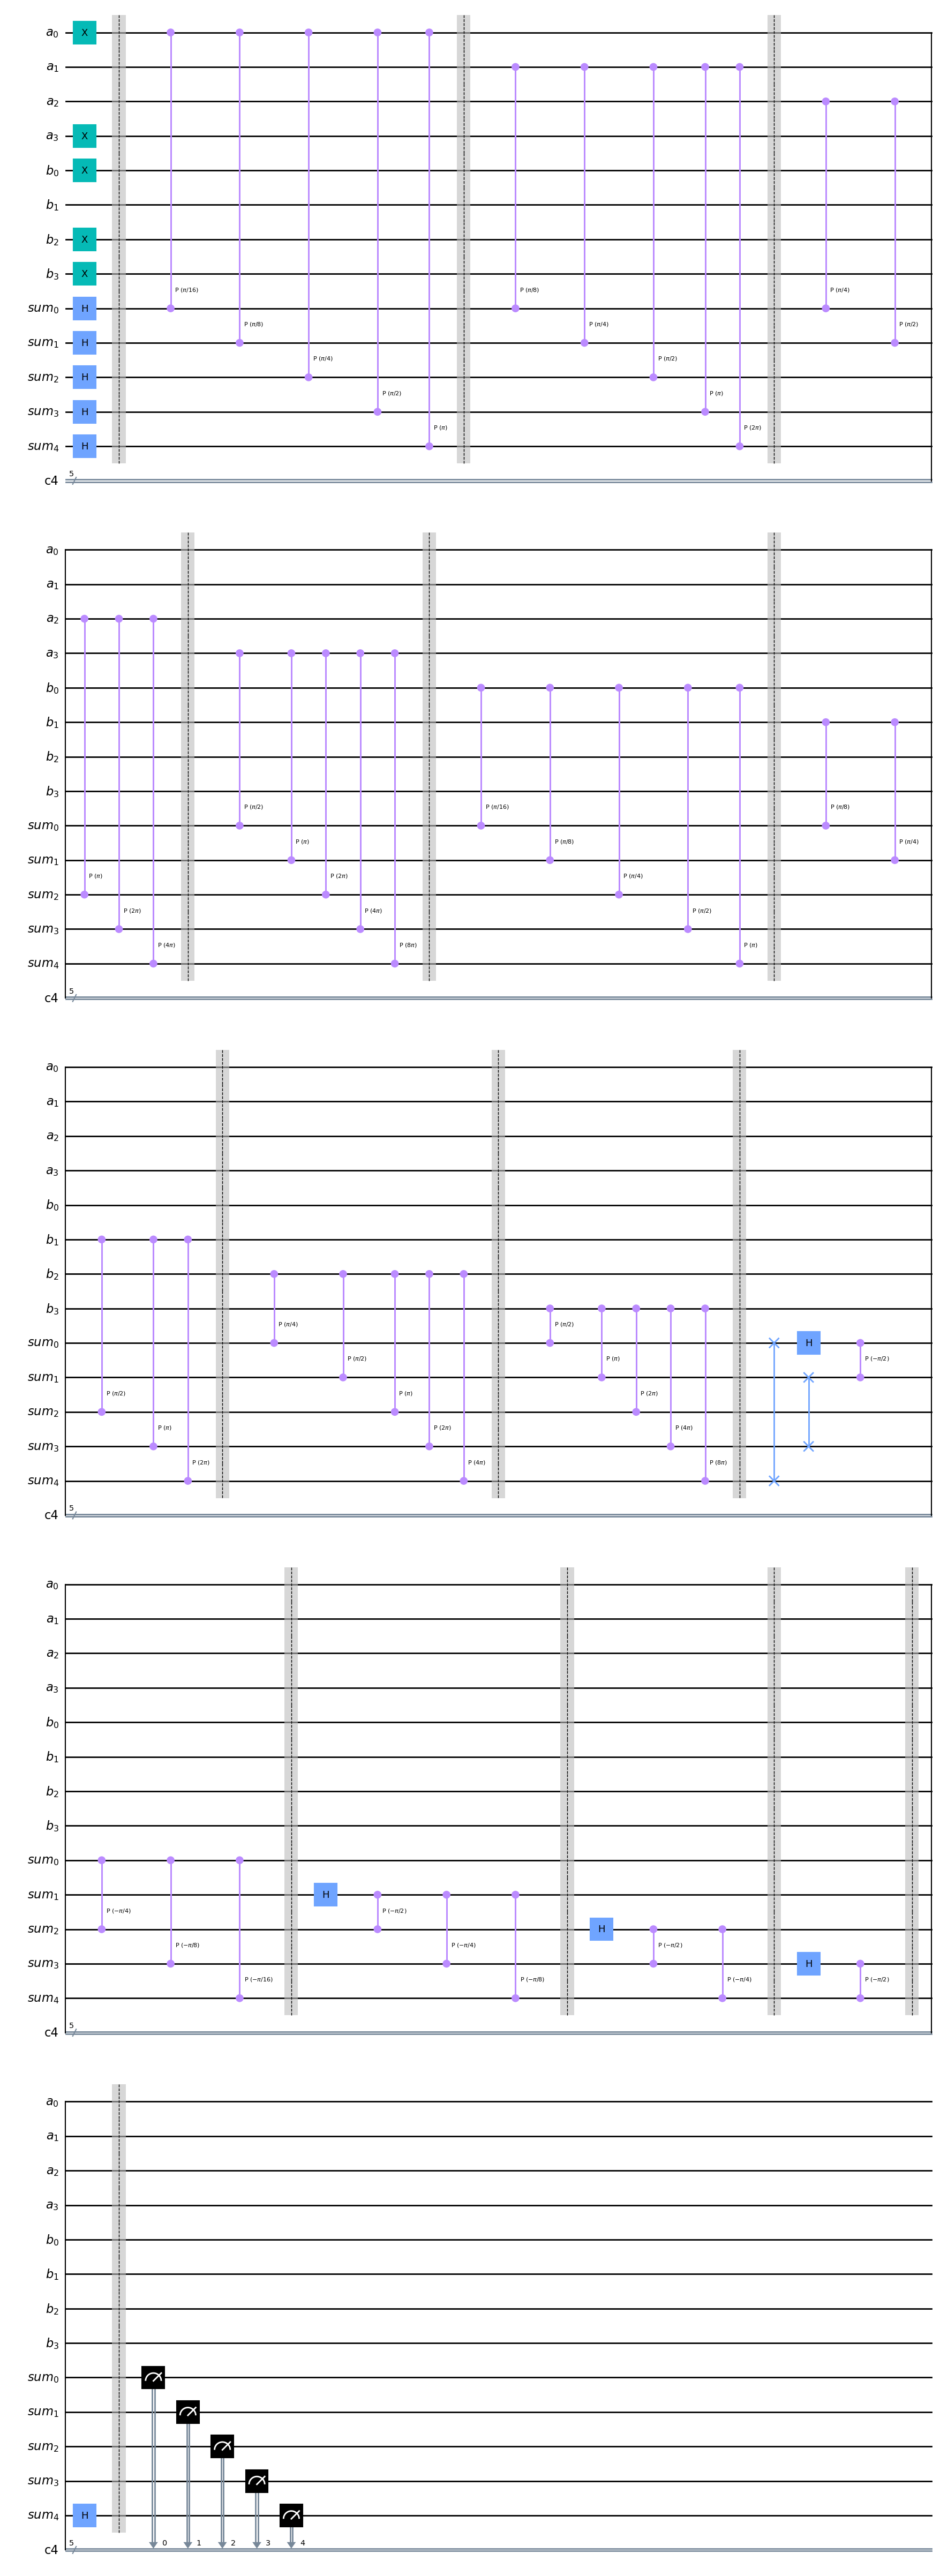

In [11]:
# a+bを計算する
a = 9
b = 13

# a,bを文字列に変換する
binary_a = bin(a)[2:]
binary_b = bin(b)[2:]

# a,b,和のレジスタを作る
a_reg = QuantumRegister(len(binary_a), 'a')
b_reg = QuantumRegister(len(binary_b), 'b')
sum_reg = QuantumRegister(max(len(binary_a),len(binary_b))+1, 'sum')

# 読み出し用の古典レジスタを作る
creg = ClassicalRegister(max(len(binary_a),len(binary_b))+1)

# 回路を生成
circuit = QuantumCircuit(a_reg, b_reg, sum_reg, creg)


# aの値をa_regに生成する
for i,bit in enumerate(reversed(binary_a)):
    if bit == '1':
        circuit.x(a_reg[i])

# bの値をb_regに生成する
for i,bit in enumerate(reversed(binary_b)):
    if bit == '1':
        circuit.x(b_reg[i])
        
# sumに量子フーリエ変換をかけて位相に変えておく
circuit.h(sum_reg)


# 位相の掛け算
phase_addition(circuit, a_reg, b_reg, sum_reg)


# 逆フーリエ変換して、2進数データに直す 
inverse_qft(circuit, sum_reg)

# 測定
circuit.measure(sum_reg, creg)

# 回路を描画
circuit.draw(output = 'mpl')

9+13=22


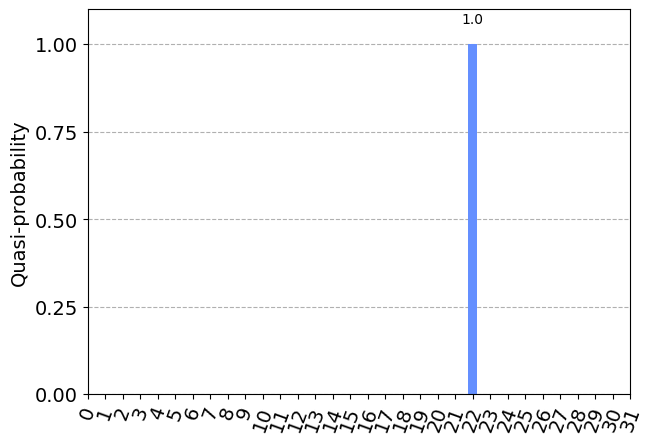

In [21]:
# シミュレータで試す
simulator = Aer.get_backend('qasm_simulator')
shots = 2048

job_sim = simulator.run(transpile(circuit, backend=simulator), shots=shots)
result = job_sim.result()
counts = result.get_counts(circuit)
total_counts = sum(counts.values())


#確率が最大の値を10進数表示で得る
add_result = int(max(counts, key=counts.get),2)

#足し算の結果を表示
print(f'{a}+{b}={add_result}')


#sumのビット数
bits = sum_reg.size


# 辞書に含まれない状態を追加し、値を0にする
for state in [format(i, f'0{bits}b') for i in range(32)]:
    if state not in counts:
        counts[state] = 0

# ヒストグラムを作成
normalized_counts = {int(state,2): count / total_counts for state, count in counts.items()}
plot_histogram(normalized_counts)

